In [98]:
import pandas as pd
import prisma_ml as prisma
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import pickle

In [99]:
df = pd.read_csv(r"../../data/processed/emotet_static.csv")

df.drop("Is Encrypted Traffic", axis=1, inplace=True)

## EDA

In [100]:
info = prisma.DatasetInformation(df)

df.drop_duplicates(inplace=True)

info.dataframe_summary()

### Shape:

(79646, 31)

### Columns and Metadata:

,Data Type,Null Values,Percentage of Nulls
Duration,float64,0,0.0
Source Port,int64,0,0.0
Destination Port,int64,0,0.0
Protocol,object,0,0.0
Flags,object,0,0.0
Packets,int64,0,0.0
Bytes,int64,0,0.0
Mean Payload Size,float64,0,0.0
Std Payload Size,float64,0,0.0
Min Payload Size,int64,0,0.0


### Duplicated Rows:

,Duplicated Rows Count
Total,0


### Categorical

In [101]:
df.columns

Index(['Duration', 'Source Port', 'Destination Port', 'Protocol', 'Flags',
       'Packets', 'Bytes', 'Mean Payload Size', 'Std Payload Size',
       'Min Payload Size', 'Max Payload Size', 'Mean Entropy', 'Min Entropy',
       'Max Entropy', 'Mean Inter-Packet Interval',
       'Min Inter-Packet Interval', 'Max Inter-Packet Interval', 'Label',
       'Bytes per Packet', 'Packets per Second', 'Bytes per Second',
       'Common Port Usage', 'flags_count', 'syn_count', 'ack_count',
       'fin_count', 'is_http', 'is_internal_ip', 'direction', 'short_duration',
       'single_packet'],
      dtype='object')

In [102]:
info = prisma.DatasetInformation(df)

info.categorical_summary()

### Categorical Columns Summary:

,Column,Unique Values Count,Top Value,Top Value Percentage
0,Protocol,4,TCP,76.17%
1,Flags,14,SYN,51.50%
2,Label,2,Benign,53.87%
3,direction,1,outbound,100.00%


### Column: Protocol

#### Value Counts and Percentage Distribution:

,Value,Count,Percentage
0,TCP,60663,76.165784
1,HTTP,14216,17.848982
2,DATA-TEXT-LINES,4743,5.955101
3,XML,24,0.030133


---

### Column: Flags

#### Value Counts and Percentage Distribution:

,Value,Count,Percentage
0,SYN,41015,51.496623
1,"PSH,ACK",18926,23.762650
2,"FIN,SYN,ACK",9294,11.669136
3,"SYN,RST,ACK",6277,7.881124
4,"FIN,SYN,RST,ACK",2958,3.713934
5,"FIN,SYN,PSH,ACK",556,0.698089
6,"SYN,ACK",289,0.362856
7,"FIN,SYN,RST,PSH,ACK",119,0.149411
8,"SYN,RST",64,0.080356
9,"SYN,PSH,ACK",53,0.066544


---

### Column: Label

#### Value Counts and Percentage Distribution:

,Value,Count,Percentage
0,Benign,42907,53.872134
1,Emotet,36739,46.127866


---

### Column: direction

#### Value Counts and Percentage Distribution:

,Value,Count,Percentage
0,outbound,79646,100.000000


---

### Numerical

In [103]:
# from sklearn.preprocessing import QuantileTransformer

# # Create the transformer (default is uniform transformation)
# quantile_transformer = QuantileTransformer(
#     output_distribution="uniform", random_state=42
# )

# # Ensure that only numeric columns are transformed
# numeric_columns = df.select_dtypes(include=[np.number]).columns
# df[numeric_columns] = quantile_transformer.fit_transform(df[numeric_columns])
# info.numerical_summary()

## Modeling

### Final Data Prep

In [104]:
def save_as_pickle(path, variable):
    with open(path, "wb") as file:
        pickle.dump(variable, file)

#### Encoding

In [105]:
encoder = LabelEncoder()

# Columns to encode
columns_to_encode = ["Protocol", "Flags", "Label", "direction"]

# Apply label encoding to each column
for column in columns_to_encode:
    # Fit label encoder and return encoded labels
    path = "../../variables/emotet/static_no_pca" + column + "_Encoder.pkl"
    df[column] = encoder.fit_transform(df[column])
    save_as_pickle(path, encoder)

#### Type Casting

In [106]:
df["Bytes"] = df["Bytes"].astype("float64")
df["Duration"] = df["Duration"].astype("float64")
df["Packets"] = df["Packets"].astype("float64")
df["flags_count"] = df["flags_count"].astype("float64")

In [107]:
df.drop(["Source Port","Destination Port"], axis=1,inplace=True)

### Data Splitting

In [108]:
# # Separate the 'Status' column
label_column = df["Label"]
dropped_df = df.drop("Label", axis=1)

# Initialize and apply MinMaxScaler to the dropped_df
scaler = StandardScaler()
scaled_dropped_df = scaler.fit_transform(dropped_df.to_numpy())
print(dropped_df.columns)
# Create a DataFrame from the scaled dropped_df
df = pd.DataFrame(scaled_dropped_df, columns=dropped_df.columns)

# Reattach the 'Status' column
df["Label"] = label_column

df.to_csv("../../data/modelling/emotet.csv")

save_as_pickle(r"../../variables/emotet/static_no_pca/scaler.pkl", scaler)

Index(['Duration', 'Protocol', 'Flags', 'Packets', 'Bytes',
       'Mean Payload Size', 'Std Payload Size', 'Min Payload Size',
       'Max Payload Size', 'Mean Entropy', 'Min Entropy', 'Max Entropy',
       'Mean Inter-Packet Interval', 'Min Inter-Packet Interval',
       'Max Inter-Packet Interval', 'Bytes per Packet', 'Packets per Second',
       'Bytes per Second', 'Common Port Usage', 'flags_count', 'syn_count',
       'ack_count', 'fin_count', 'is_http', 'is_internal_ip', 'direction',
       'short_duration', 'single_packet'],
      dtype='object')


## Models

### Model Creation and Parameters

In [109]:
#! Model Evaluation
test_size = 0.3
iterations = 30

#! KNN
n_neighbors = 5
knn_train_model = KNeighborsClassifier(n_neighbors=n_neighbors)

#! Random Forest
n_estimators = 100  # You can adjust this number as needed
rf_train_model = RandomForestClassifier(n_estimators=n_estimators)

#! Logistic Regression
max_iter = 5000
logreg_model = LogisticRegression(max_iter=max_iter)

In [110]:
df["Label"].isna().value_counts()

Label
False    79625
True        21
Name: count, dtype: int64

### Splitting

In [111]:
# Reset the index to convert it to a normal column (if needed)
df.dropna(inplace=True)
df_reset = df.reset_index(drop=True)  # This will drop the old index column
X = df_reset.drop("Label", axis=1)  # Now drop the Label
if 'index' in X.columns:
    X.drop('index', axis=1, inplace=True)
y = df["Label"]



In [113]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

X_lstm = np.expand_dims(X, axis=1)

# Train-test split
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    X_lstm, y, test_size=0.2, random_state=42, stratify=y
)

# Build the LSTM model
model = Sequential(
    [
        LSTM(
            128, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True
        ),
        Dropout(0.2),
        LSTM(64, return_sequences=False),
        Dropout(0.2),
        Dense(64, activation="relu"),
        Dropout(0.2),
        Dense(
            y.shape[1] if len(y.shape) > 1 else 1,
            activation="sigmoid",
        ),
    ]
)

# Compile the model
model.compile(
    optimizer="adam",
    loss= "binary_crossentropy",
    metrics=["accuracy"],
)

# Train the model
history = model.fit(
    X_train_lstm, y_train_lstm, validation_data=(X_test_lstm, y_test_lstm), epochs=20, batch_size=64
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_lstm, y_test_lstm)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
996/996 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8163 - loss: 0.4498 - val_accuracy: 0.8513 - val_loss: 0.3739
Epoch 2/20
996/996 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8461 - loss: 0.3807 - val_accuracy: 0.8522 - val_loss: 0.3663
Epoch 3/20
996/996 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8483 - loss: 0.3740 - val_accuracy: 0.8522 - val_loss: 0.3543
Epoch 4/20
996/996 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8490 - loss: 0.3628 - val_accuracy: 0.8485 - val_loss: 0.3531
Epoch 5/20
996/996 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8524 - loss: 0.3604 - val_accuracy: 0.8596 - val_loss: 0.3486
Epoch 6/20
996/996 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8545 - loss: 0.3565 - val_accuracy: 0.8602 - val_loss: 0.3470
Epoch 7/20
996/996 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8534 - loss: 0.3567 - val_accuracy: 0.8600 - val_loss: 0.3475
Epoch 8/20
996/996 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8520 - loss: 0.3584 - val_accuracy: 0

### KNN

In [ ]:
knn_normal = prisma.MachineLearning()
knn_normal_metrics, avg_knn_normal_metrics, knn_normal_model = (
    knn_normal.evaluate_model(X, y, test_size, iterations, knn_train_model)
)

### Random Forest

In [ ]:
rf_normal = prisma.MachineLearning()
(
    rf_normal_metrics,
    avg_rf_normal_metrics,
    rf_normal_model,
) = rf_normal.evaluate_model(X, y, test_size, iterations, rf_train_model)

### Logistic Regression

In [ ]:


logreg_normal = prisma.MachineLearning()
(
    logreg_normal_metrics,
    avg_logreg_normal_metrics,
    logreg_normal_model,
) = logreg_normal.evaluate_model(X, y, test_size, iterations, logreg_model)

### Model Evaluation

In [ ]:
normal_metrics = {"KNearestNeighbor":avg_knn_normal_metrics, "RandomForest":avg_rf_normal_metrics, "Logistic Regression":avg_logreg_normal_metrics}
plot = prisma.Plotting(df)

plot.plot_algorithm_comparison(normal_metrics)

In [ ]:
normal_metrics

In [20]:
save_as_pickle(r"../../models/Rbot_KNN.pkl", knn_normal_model)

In [ ]:
avg_logreg_normal_metrics


In [ ]:
logreg_normal_metrics

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with seaborn
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)

# Display the heatmap
plt.show()

In [112]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

# Define the XGBoost classifier with default settings
xgb_model = xgb.XGBClassifier(
    max_depth=3,
    n_estimators=100,  # Control the number of trees
    learning_rate=0.125,  # Decreased learning rate
    random_state=23  # For reproducibility
)
#! 0.1, 0.11,
# Fit the model on training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy:  0.8645344943067649
Confusion Matrix:
 [[11104  1765]
 [ 1471  9548]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.86      0.87     12869
         1.0       0.84      0.87      0.86     11019

    accuracy                           0.86     23888
   macro avg       0.86      0.86      0.86     23888
weighted avg       0.87      0.86      0.86     23888



In [ ]:
# Check the performance on the training data
y_train_pred = xgb_model.predict(X_test)

# Evaluate on training data
train_accuracy = accuracy_score(y_test, y_train_pred)
print(f"Training Accuracy: {train_accuracy}")


In [ ]:
from sklearn.model_selection import cross_val_score

# Perform k-fold cross-validation
cv_scores = cross_val_score(xgb_model, X, y, cv=5)

# Print the average accuracy across the folds
print(f"Cross-Validation Accuracy: {cv_scores.mean()}")


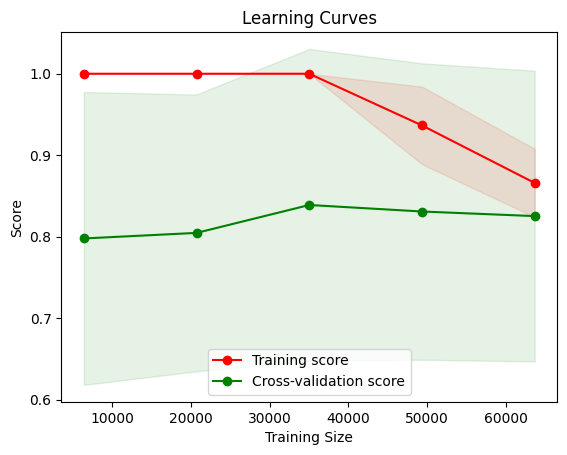

In [114]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    xgb_model, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
)

# Calculate mean and standard deviation for training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")

plt.xlabel("Training Size")
plt.ylabel("Score")
plt.title("Learning Curves")
plt.legend(loc="best")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
xgb.plot_importance(xgb_model)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    logreg_normal_model, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
)

# Calculate mean and standard deviation for training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.plot(train_sizes, train_mean, "o-", color="r", label="Training score")
plt.plot(train_sizes, test_mean, "o-", color="g", label="Cross-validation score")

plt.fill_between(
    train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r"
)
plt.fill_between(
    train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g"
)

plt.xlabel("Training Size")
plt.ylabel("Score")
plt.title("Learning Curves")
plt.legend(loc="best")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    knn_normal_model, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
)

# Calculate mean and standard deviation for training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.plot(train_sizes, train_mean, "o-", color="r", label="Training score")
plt.plot(train_sizes, test_mean, "o-", color="g", label="Cross-validation score")

plt.fill_between(
    train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r"
)
plt.fill_between(
    train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g"
)

plt.xlabel("Training Size")
plt.ylabel("Score")
plt.title("Learning Curves")
plt.legend(loc="best")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    rf_normal_model, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
)

# Calculate mean and standard deviation for training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.plot(train_sizes, train_mean, "o-", color="r", label="Training score")
plt.plot(train_sizes, test_mean, "o-", color="g", label="Cross-validation score")

plt.fill_between(
    train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r"
)
plt.fill_between(
    train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g"
)

plt.xlabel("Training Size")
plt.ylabel("Score")
plt.title("Learning Curves")
plt.legend(loc="best")
plt.show()

In [32]:
save_as_pickle(r"../../models/emotet/logreg.pkl", logreg_normal_model)

In [ ]:
y_pred = logreg_normal_model.predict(X_test)

# Evaluate the model
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.displot(df["Max Entropy"])

plt.show()